# SOM

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir('../../scripts')
from som.selfsom import SimpleSOMMapper
import som.somtools
from som.TransitSOM_release import CreateSOM
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

---

## Stacking .npz files

In [2]:
def stack_npz_files(directory):
    
    """normalisation method: median, depth, depth and width"""
    
    files = os.listdir(directory)
    npz_files = [f for f in files if f.endswith('.npz')]
    if not npz_files:
        print("No .npz files found in the directory.")
        return None

    normalised_by_median = []
    normalised_by_depth = [] 
    ids = []
    
    for npz_file in npz_files:
        file_path = os.path.join(directory, npz_file)
        data = np.load(file_path)   

        
        ## background subtraction
        x1 = np.median(data['flux'][0:12])
        x2 = np.median(data['flux'][-13:-1]) # the last 12 points

        y1 = np.median(data['time'][0:24])
        y2 = np.mean(data['time'][-25:-1])
        grad = (x2-x1)/(y2-y1)
        background_level = x1 + grad * (data['time'] - y1)
        original_flux = data['flux'].copy()
        
        flux = original_flux - background_level

        obj_id = data['id']
        
        ## normalisation method
        
               
        normalised_lightcurve = (flux)/np.median(flux)
        median = np.median(flux)
        #depth_normalised_lightcurve = (data['flux'] - median) / median
        abs_depth = median - np.min(flux)  # Assuming the minimum of the lightcurve is the minimum point
        depth_normalised_lightcurve = ((flux - median) / abs_depth + 1)
        #elif normalisation_method == 'depth and width':
        
        abs_depth_unsubtracted = np.median(original_flux) - np.min(original_flux)
        depth_normalised_lightcurve_unsubtracted = ((original_flux - np.median(original_flux)) / abs_depth_unsubtracted + 1)
        
        #fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns of subplots
        
        ##ax[0].scatter(data['time'],depth_normalised_lightcurve,s=5)
        #ax[0].set_title("TIC {} - unsubtracted background".format(data['id']))
        #ax[1].scatter(data['time'],depth_normalised_lightcurve_unsubtracted,s=5)
        #ax[1].set_title("TIC {} - subtracted background".format(data['id']))
        #plt.title(data['id'])
        #plt.show()
        
        
#         normalised_lightcurve = (data['flux'])/np.median(data['flux'])
#         median = np.median(data['flux'])
#         #depth_normalised_lightcurve = (data['flux'] - median) / median
#         abs_depth = median - np.min(data['flux'])  # Assuming the minimum of the lightcurve is the minimum point
#         depth_normalised_lightcurve = ((data['flux'] - median) / abs_depth + 1)
#         #elif normalisation_method == 'depth and width':
#         plt.scatter(data['time'],depth_normalised_lightcurve,s=5)
#         plt.title(data['id'])
#         plt.show()
        
        
        if len(normalised_lightcurve) == 121:
            normalised_by_median.append(normalised_lightcurve)
            normalised_by_depth.append(depth_normalised_lightcurve)
            ids.append(obj_id.item())


    stacked_median_lcs = np.vstack(normalised_by_median)
    stacked_depth_lcs = np.vstack(normalised_by_depth)
    stacked_ids = ids

    # Create a dictionary to map arrays to IDs
    id_map = {tuple(array): id for array, id in zip(stacked_median_lcs, stacked_ids)}
    return stacked_median_lcs, stacked_depth_lcs, stacked_ids, id_map

In [3]:
som_array2, som_array, ids, id_map = stack_npz_files('../som_cutouts_snr6_old/')

## Train SOM

In [4]:
# kshape = (15,15)
# niter  = 1000

# SOM = SimpleSOMMapper(kshape, niter)

# print('som is training')

# SOM.train(som_array)

# print('training ended')

# K = SOM.K


In [5]:
kshape = (12,12)

In [6]:
trained_data = CreateSOM(som_array,somshape=kshape,niter=1000,learningradius=0.1)

## map the data onto a pixel
mapped = trained_data(som_array)
mapped_tuples = [tuple(point) for point in mapped]
## count how many are in that pixel
counts = Counter(mapped_tuples)
count_list = [counts[item] for item in mapped_tuples]

In [7]:
trained_data

SimpleSOMMapper(kshape=(12, 12), niter=1000, learning_rate=0.100000, iradius=0.100000)

In [8]:
K = trained_data.K

In [9]:
K.shape

(12, 12, 121)

---
## Plot Kohonen layers

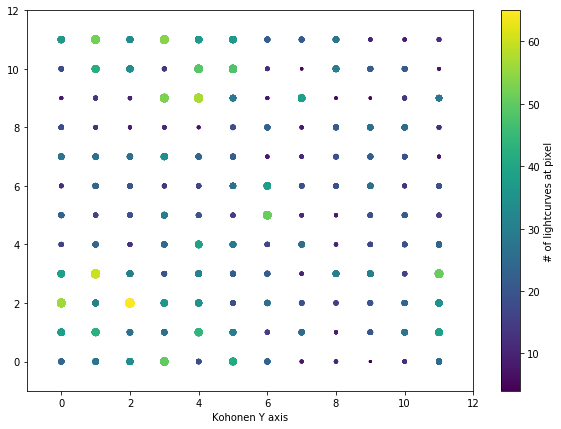

In [10]:
x_pos = mapped[:,0]
y_pos = mapped[:,1]
count_list = [counts[item] for item in mapped_tuples]
plt.figure(figsize=(10,7))
plt.xlim([-1,kshape[0]])
plt.ylim([-1,kshape[1]])
plt.xlabel('Kohonen X axis')
plt.xlabel('Kohonen Y axis')
plt.scatter(x_pos,y_pos,c=count_list,s=count_list)
plt.colorbar(label='# of lightcurves at pixel')
plt.savefig('kohonen_layers.png')
plt.show()

### Plot average lightcurve in each pixel

In [11]:
def quick_K_pixel_plot_revisited(som,x_pixel,y_pixel,bins=np.arange(121),save=False):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(bins, som[x_pixel,y_pixel],c='g')

In [12]:
array = trained_data.K

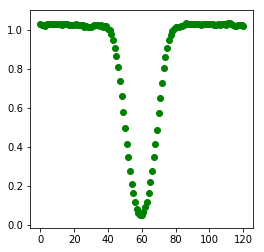

In [13]:
quick_K_pixel_plot_revisited(array,0,1)

In [14]:
def plot_all_arrays(som, bins=np.arange(121), save=True,save_path='kohonen_pixels_snr6_old.png',kshape=kshape):
    """
    
    save_path = please remember to add the suffix (eg: .png)
    """
    fig, axes = plt.subplots(kshape[0],kshape[1], figsize=(50, 50),sharey=True)
    #fig.subplots_adjust(hspace=0.5)  # Adjust the spacing between subplots
    fig.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust the width and height spacing between subplots

    for x_pixel in range(kshape[0]):
        for y_pixel in range(kshape[1]):
            ax = axes[x_pixel, y_pixel]
            ax.scatter(bins, som[x_pixel, y_pixel], c='g',s=3)
            ax.set_title('Kohonen pixel at [{},{}]'.format(x_pixel, y_pixel))
            #ax.set_ylim(0, max(som[x_pixel, y_pixel]))
            #ax.text(0, 0.92, '[{},{}]'.format(x_pixel, y_pixel))
    
    if save:
        plt.savefig('{}'.format(save_path),dpi=200)  # Save the figure if save is True
    
    plt.show()

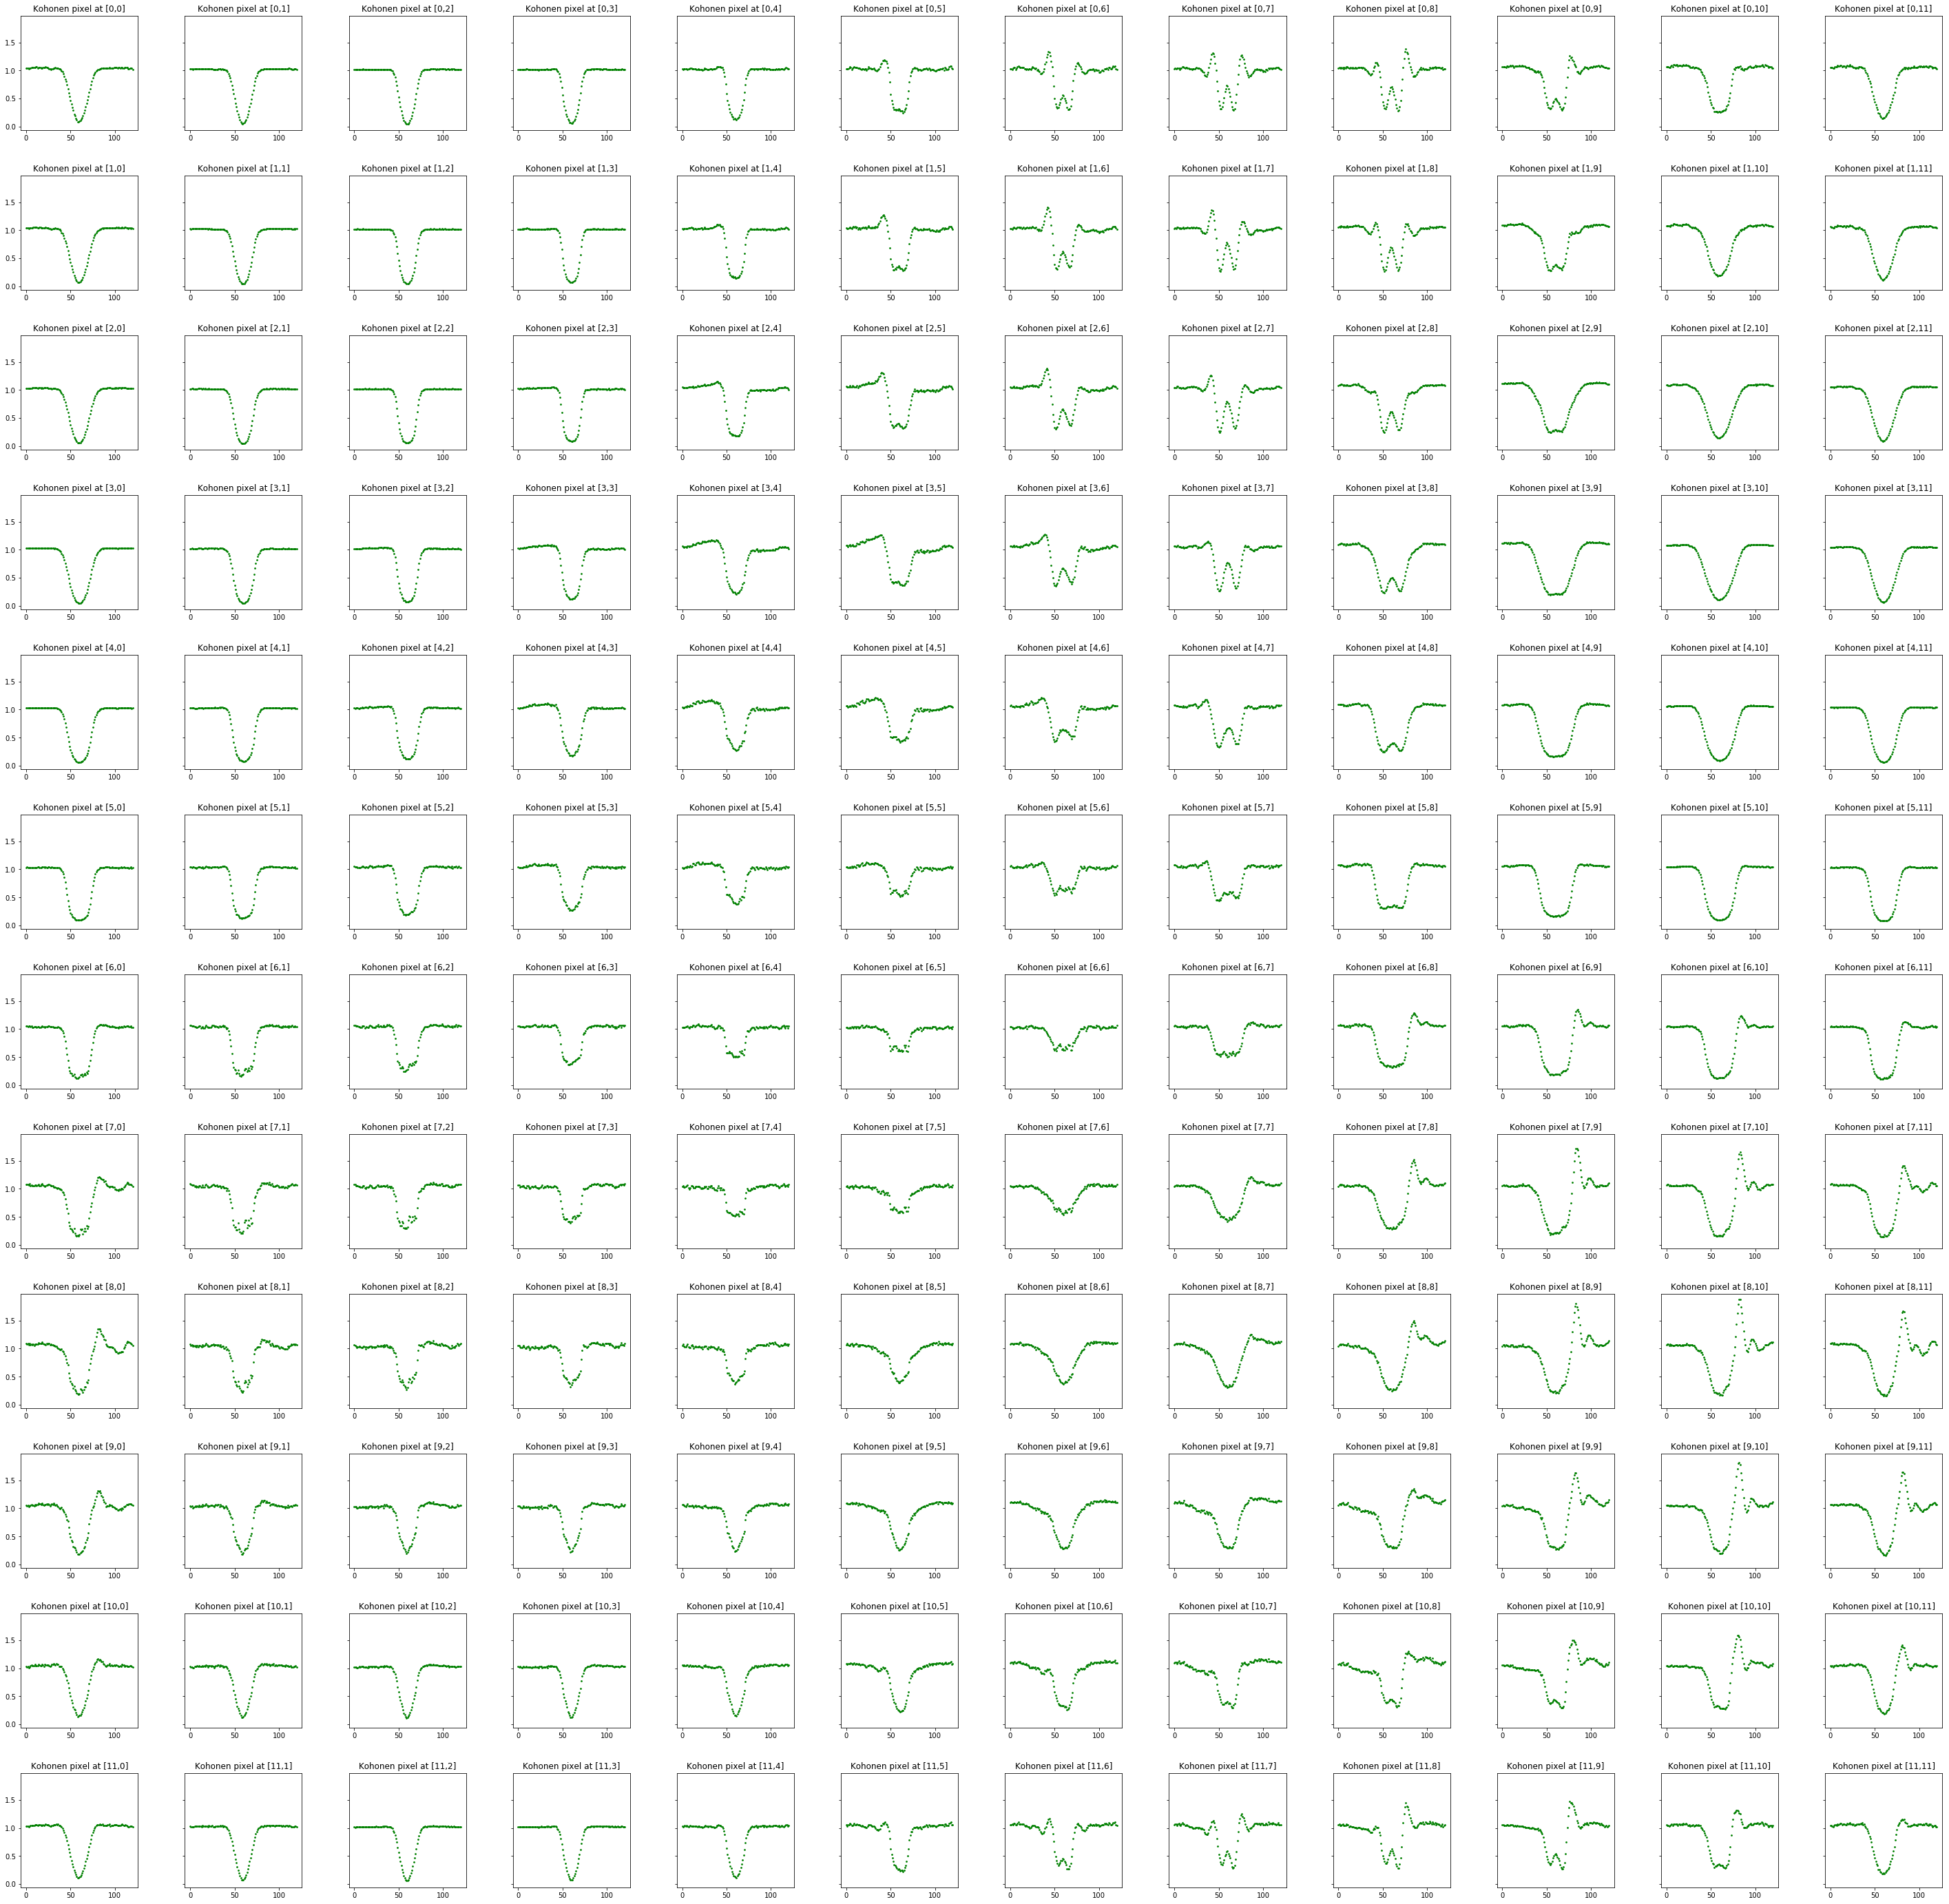

In [15]:
plot_all_arrays(array)

---
### Night mode

In [16]:
# def plot_all_arrays(som, bins=np.arange(121), save=True, save_path='kohonen_pixels_map.png', transparent=True):
#     """
#     save_path = please remember to add the suffix (e.g., .png)
#     """
#     fig, axes = plt.subplots(kshape[0], kshape[1], figsize=(50, 50), sharey=True)
#     # fig.subplots_adjust(hspace=0.5)  # Adjust the spacing between subplots
#     fig.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust the width and height spacing between subplots

#     for x_pixel in range(kshape[0]):
#         for y_pixel in range(kshape[1]):
#             ax = axes[x_pixel, y_pixel]
#             ax.scatter(bins, som[x_pixel, y_pixel], c='white', s=3)  # Set color to white
#             ax.set_title('Kohonen pixel at [{},{}]'.format(x_pixel, y_pixel), color='white')  # Set title color to white
#             ax.set_facecolor('black')  # Set the subplot background color to black
#             ax.xaxis.label.set_color('white')  # Set x-axis label color to white
#             ax.yaxis.label.set_color('white')  # Set y-axis label color to white
#             ax.spines['bottom'].set_color('white')  # Set bottom spine color to white
#             ax.spines['top'].set_color('white')  # Set top spine color to white
#             ax.spines['right'].set_color('white')  # Set right spine color to white
#             ax.spines['left'].set_color('white')  # Set left spine color to white
#             ax.tick_params(axis='both', colors='white')  # Set tick colors to white

#     if transparent:
#         fig.patch.set_facecolor('none')  # Set the figure background to transparent

#     if save:
#         plt.savefig('tranasparent_{}'.format(save_path), dpi=200, transparent=transparent)  # Save the figure if save is True

#     plt.show()

In [17]:
# plot_all_arrays(array)

---
### What lightcurve ID's are underneath each pixel?

In [25]:
os.chdir('automated_exocomet_hunt/')

In [26]:
from matplotlib.backends.backend_pdf import PdfPages


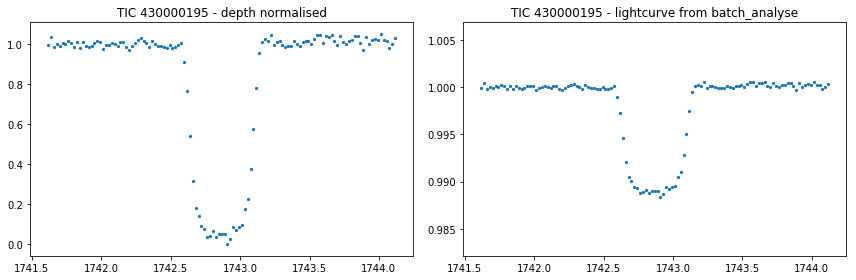

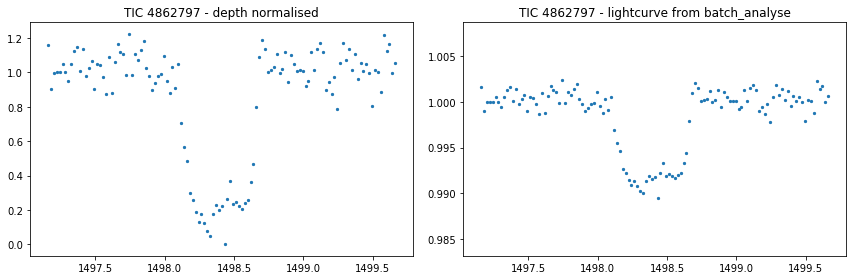

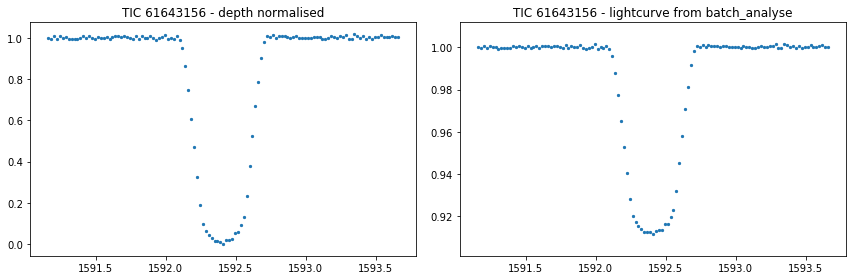

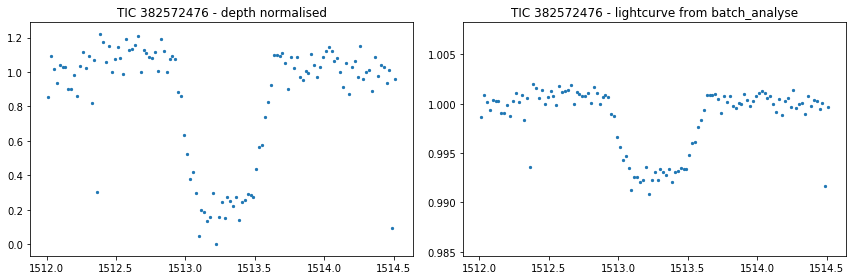

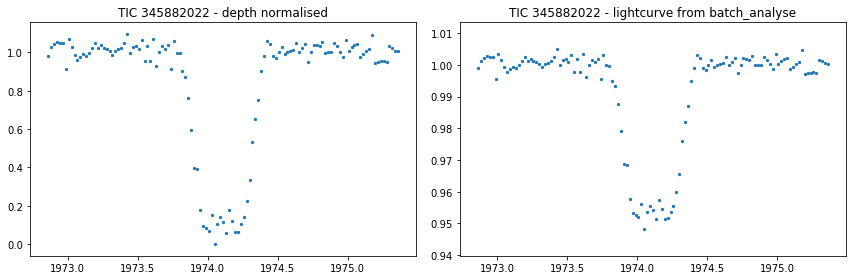

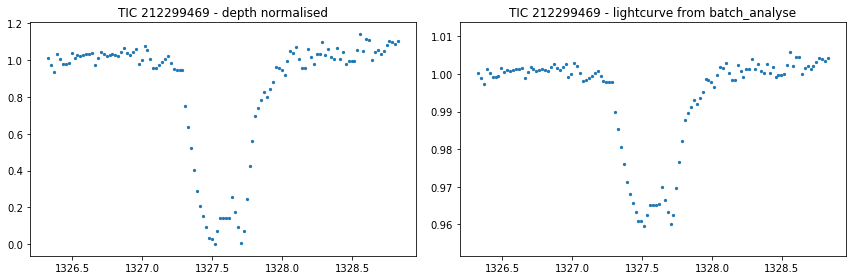

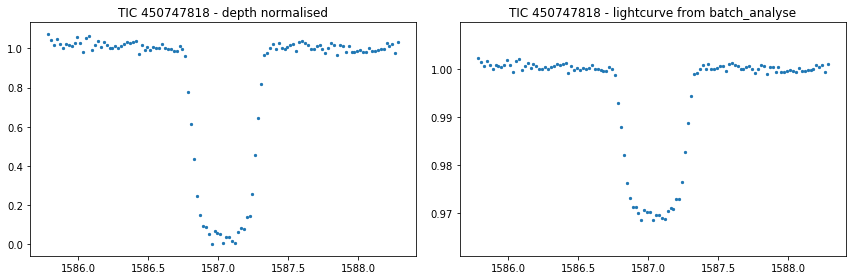

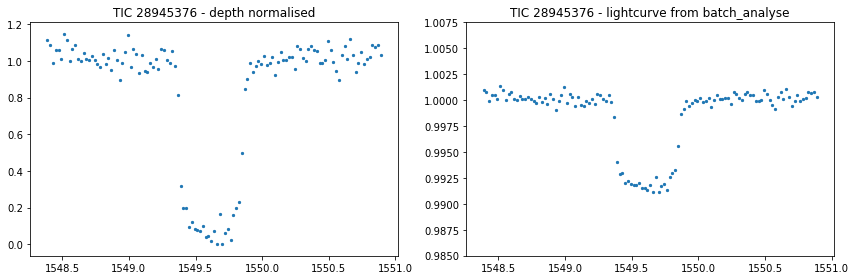

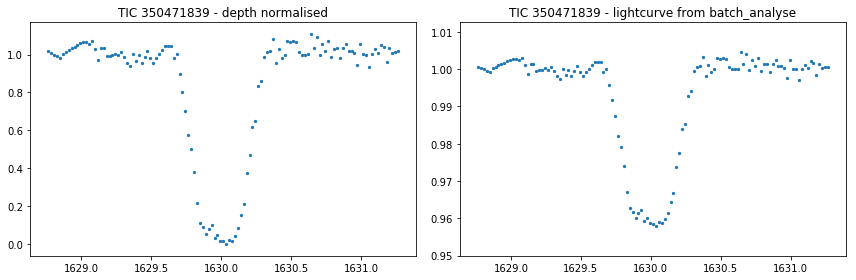

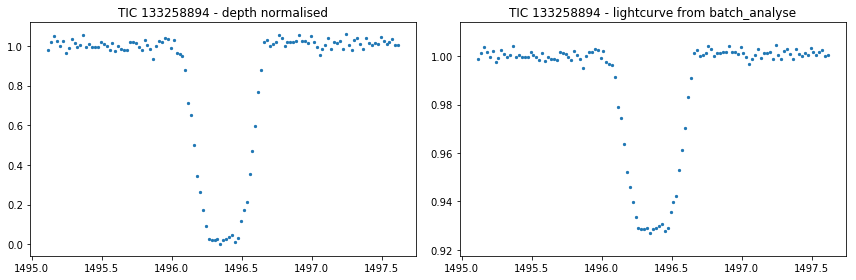

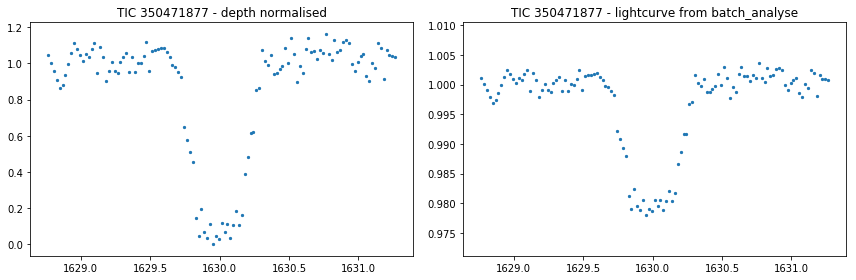

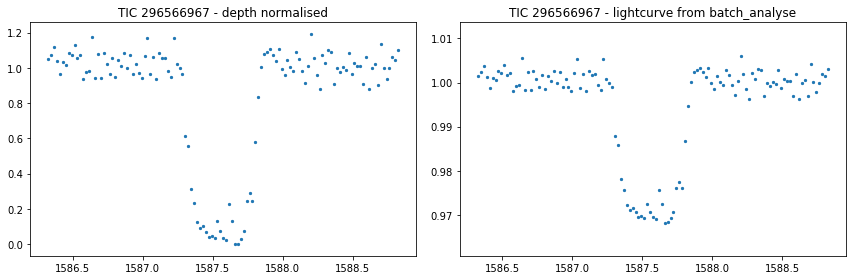

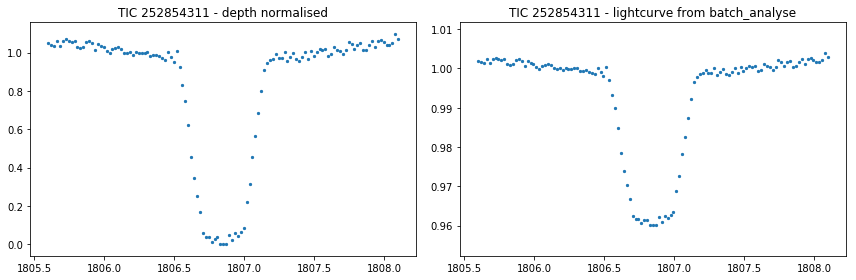

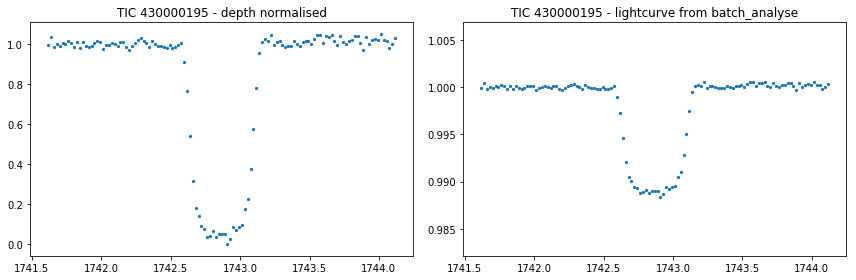

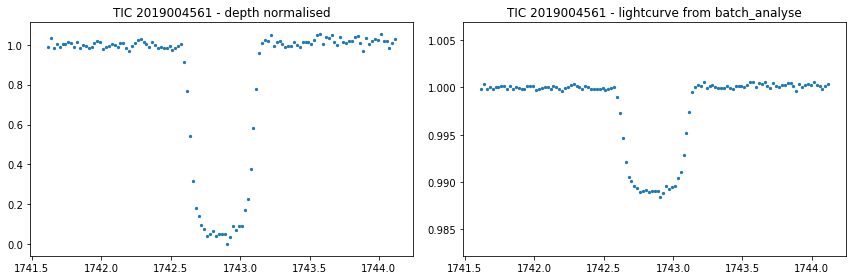

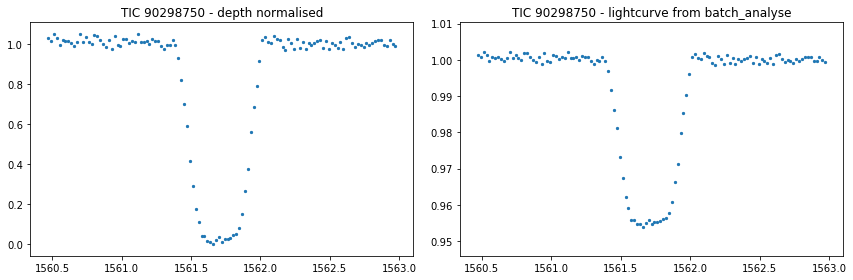

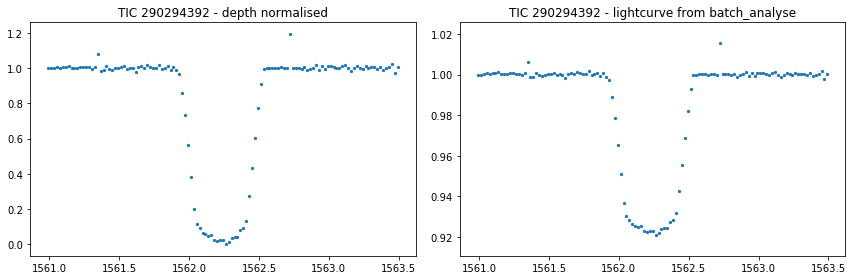

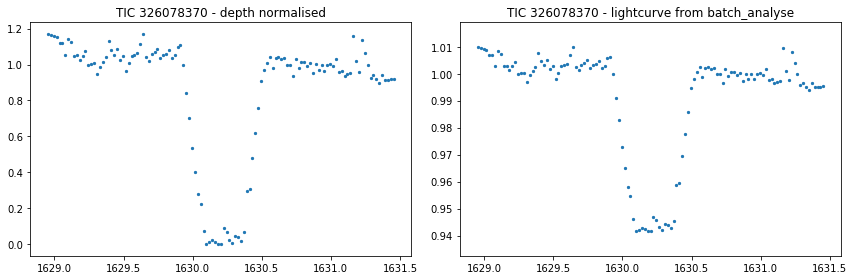

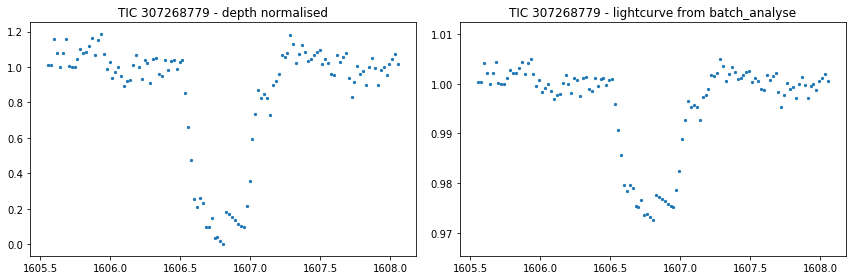

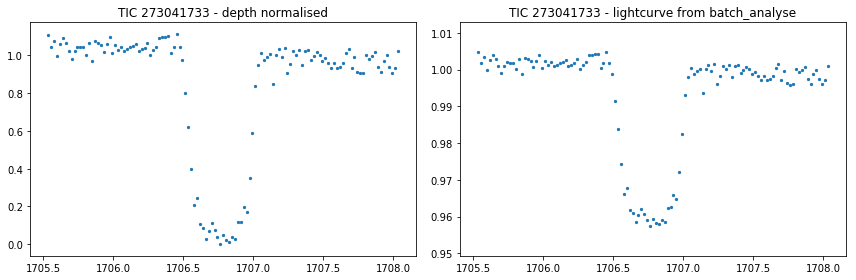

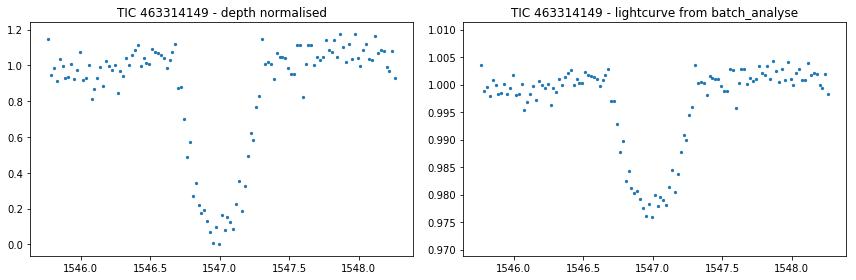

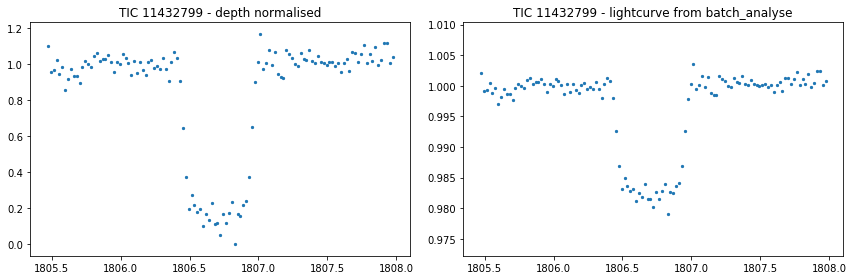

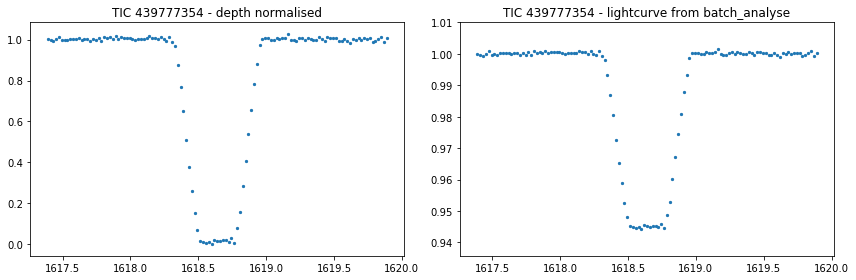

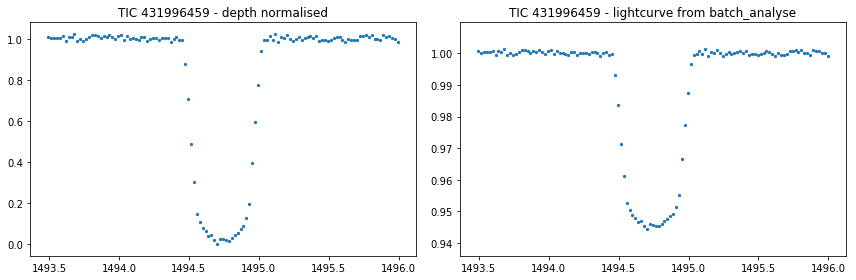

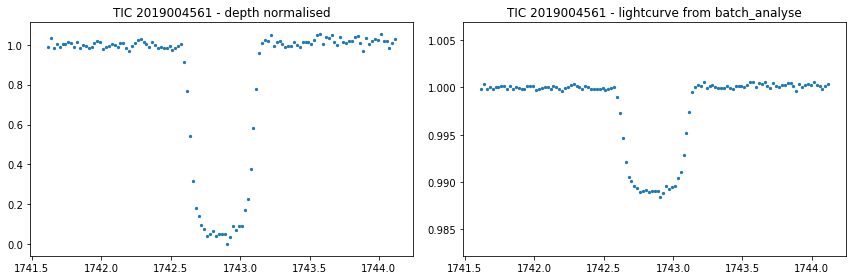

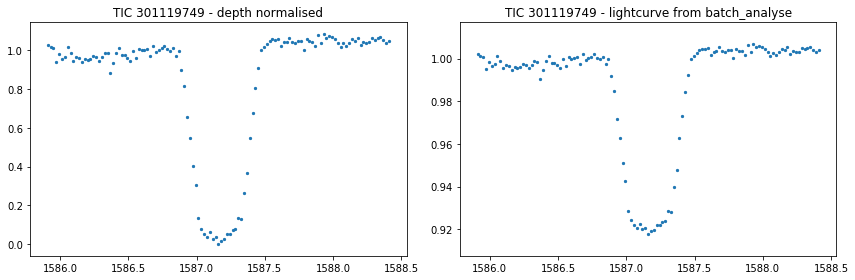

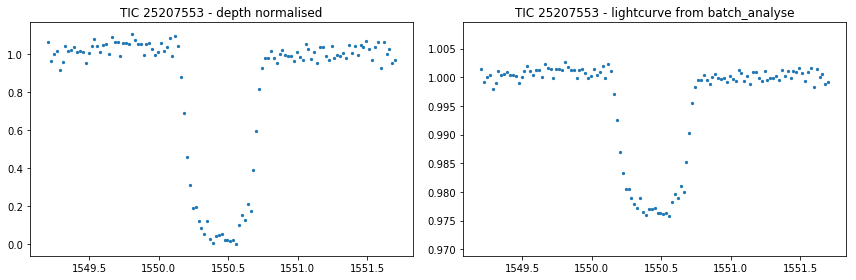

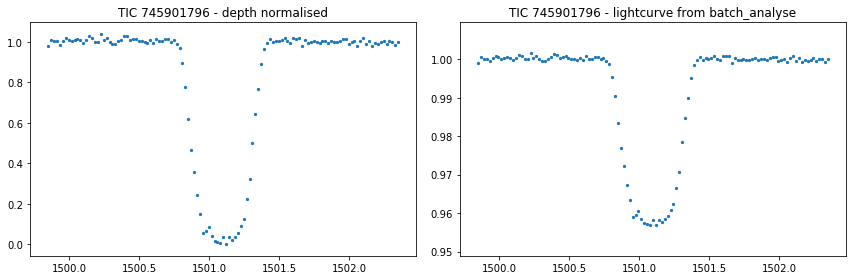

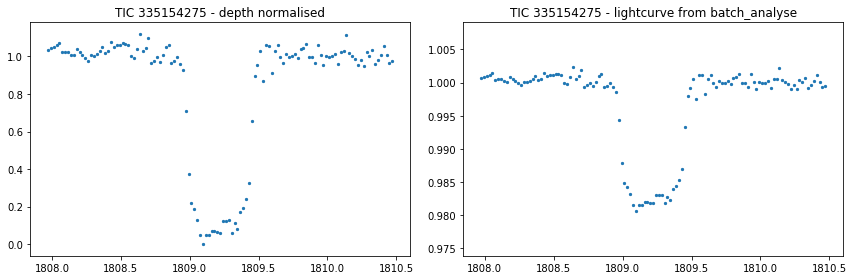

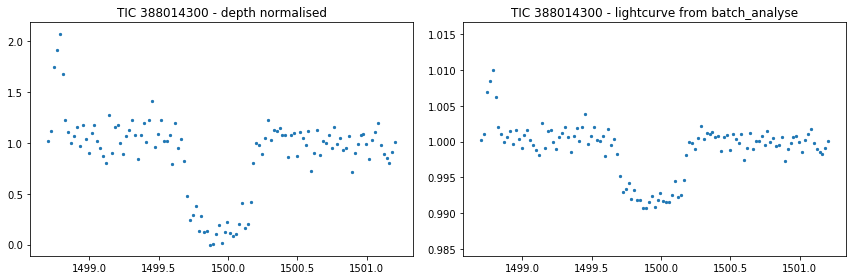

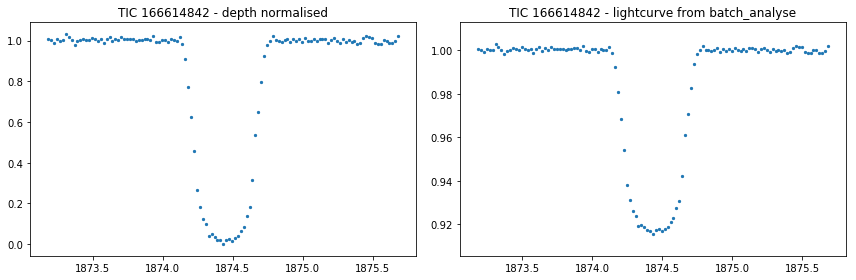

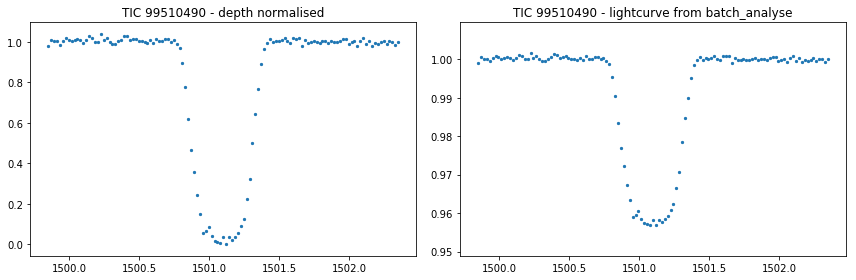

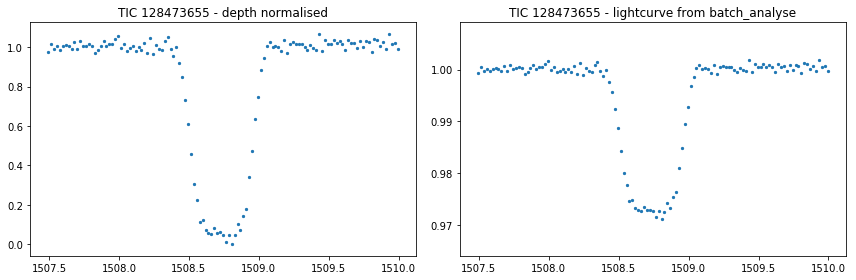

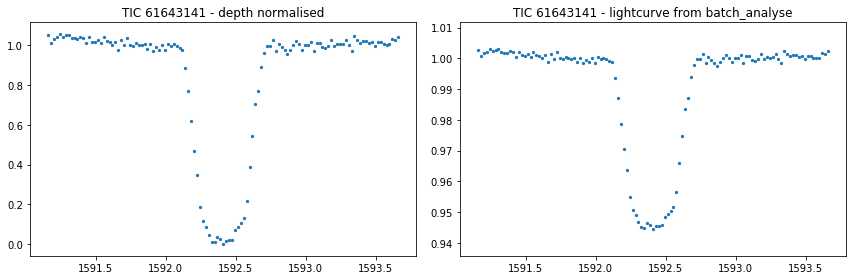

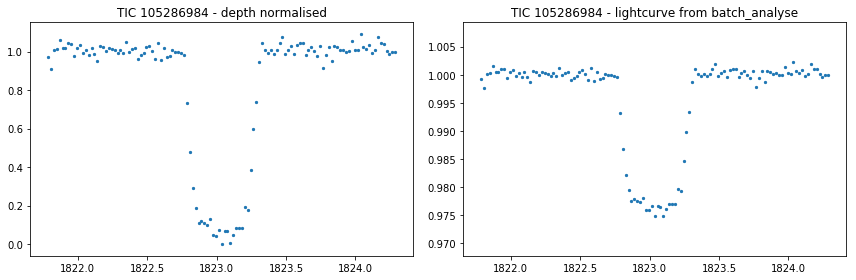

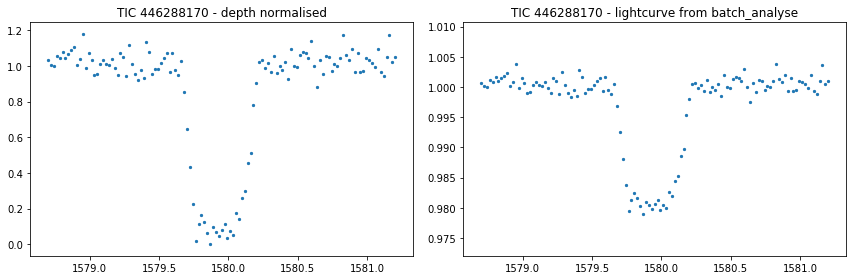

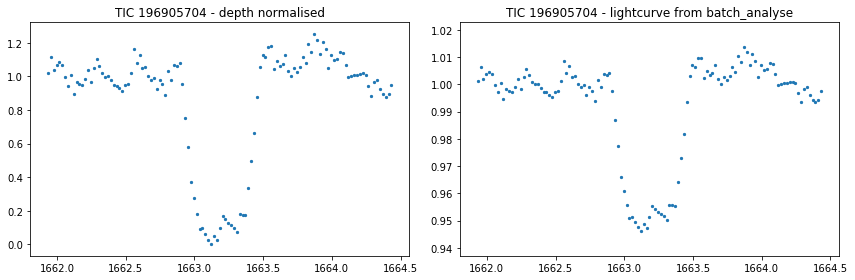

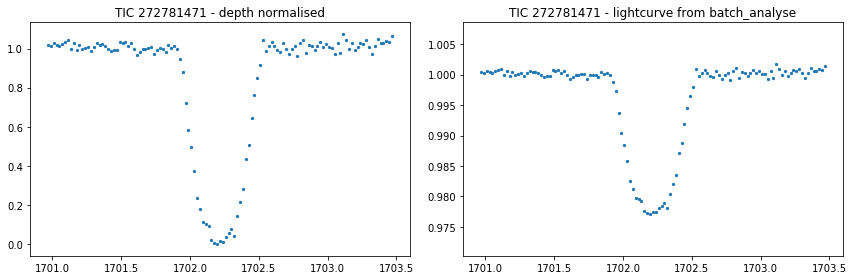

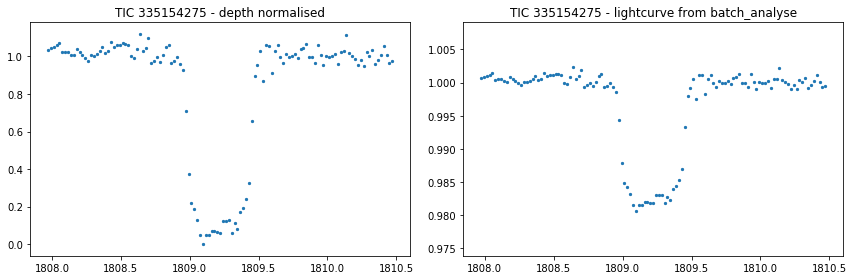

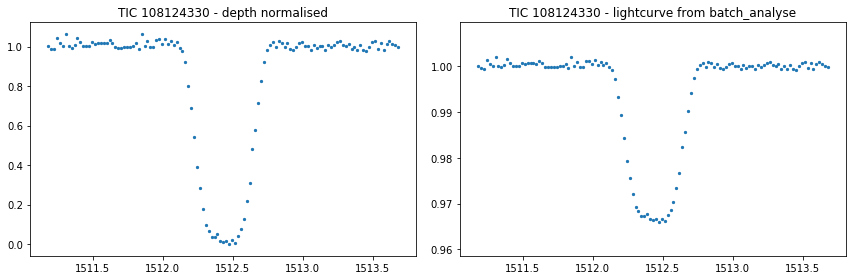

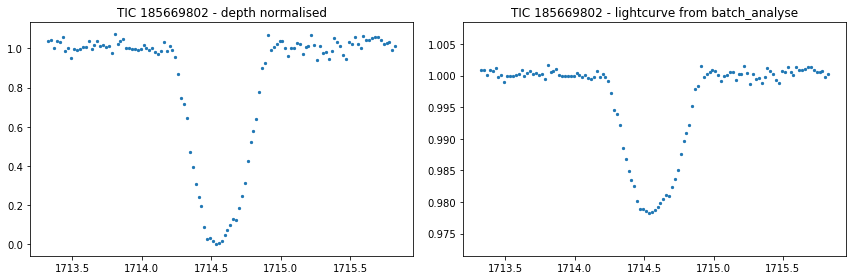

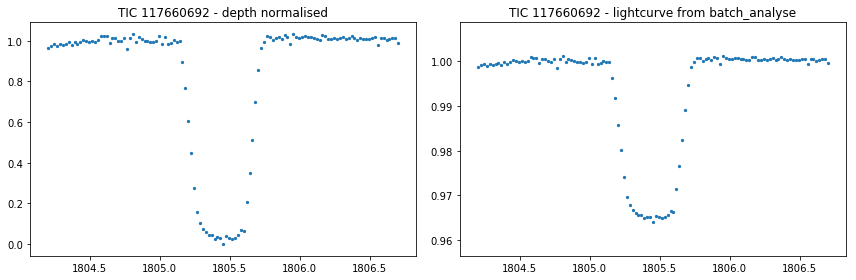

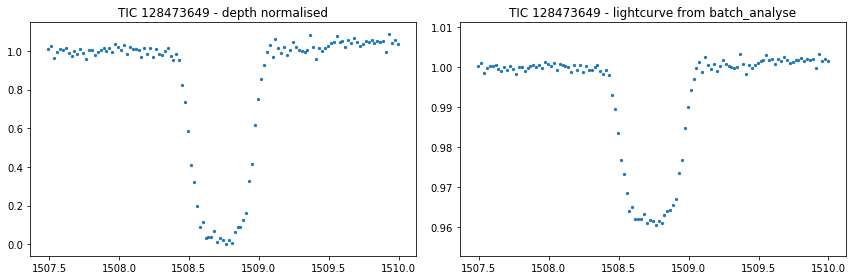

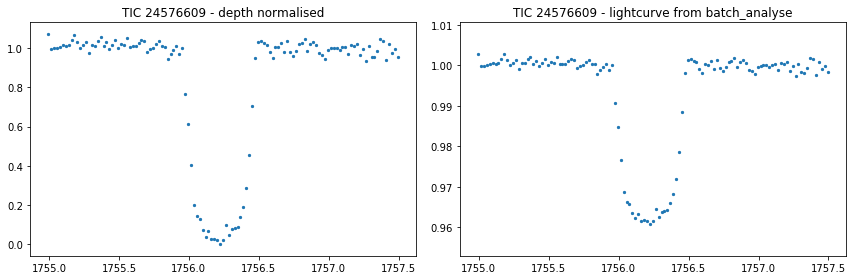

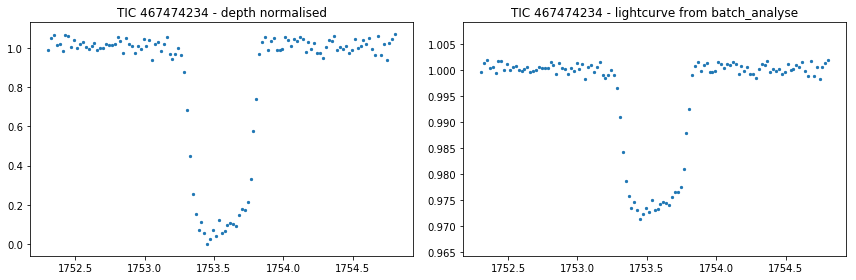

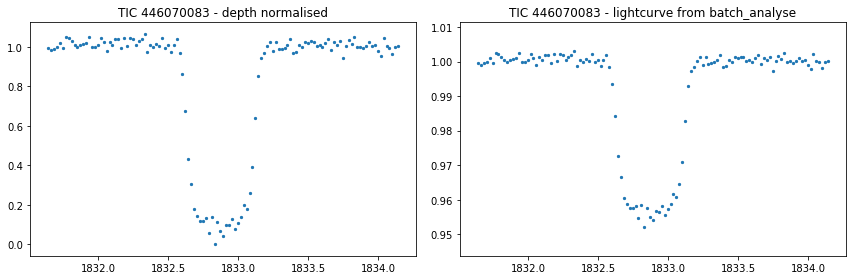

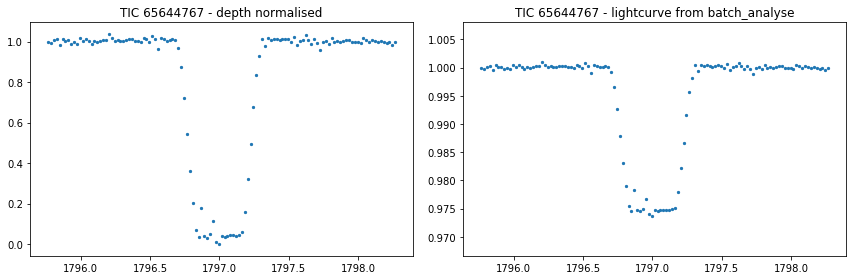

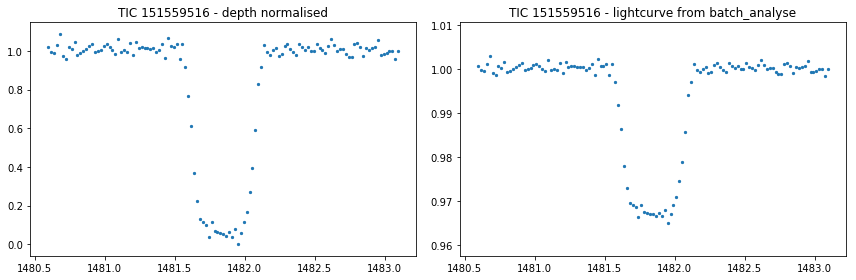

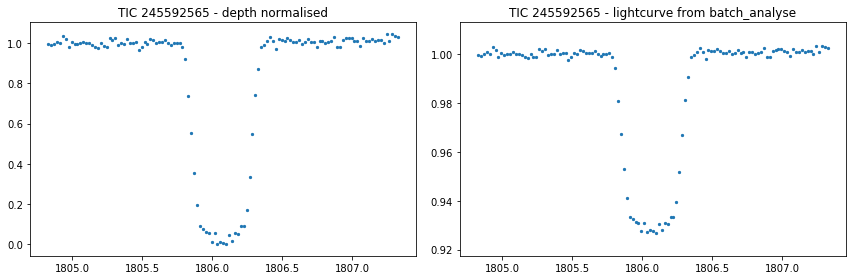

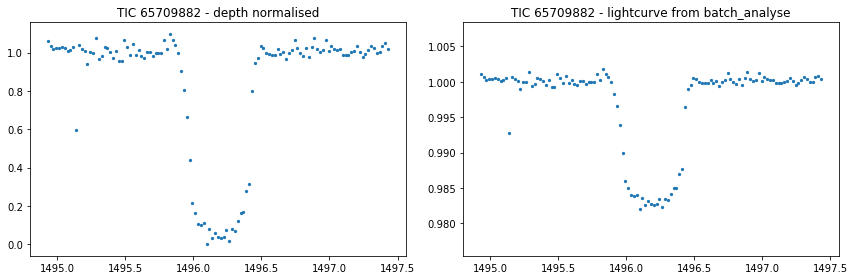

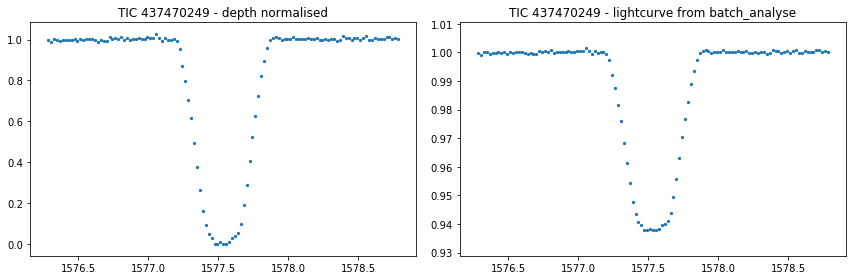

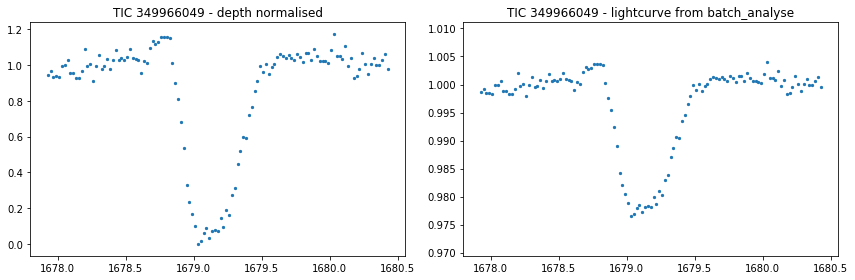

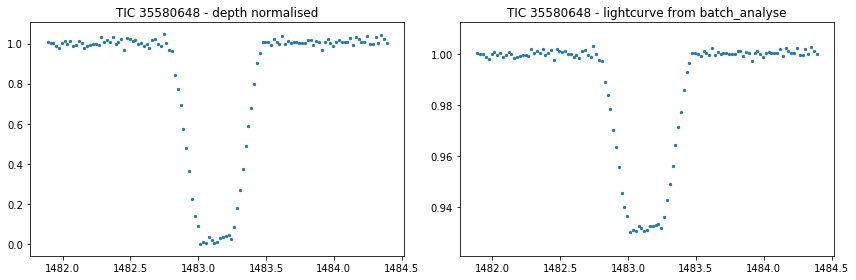

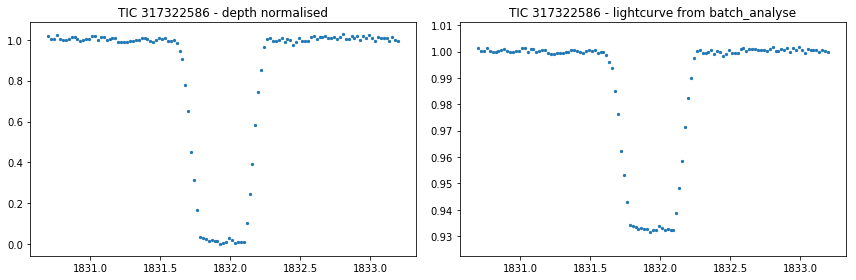

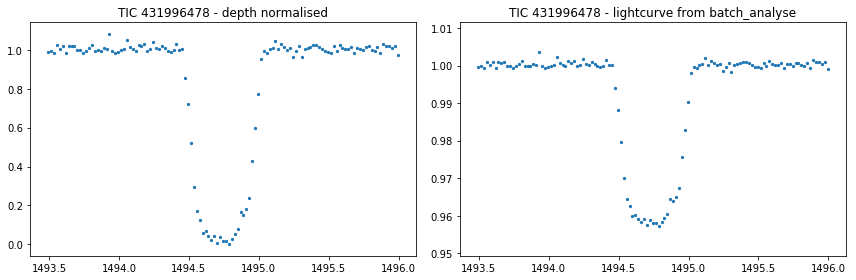

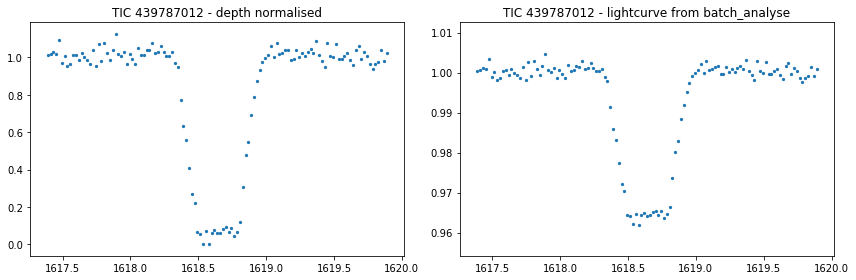

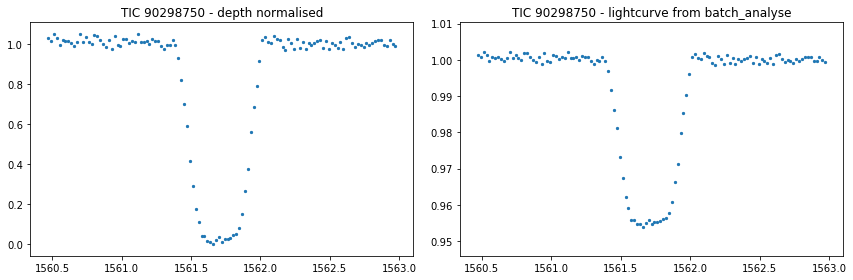

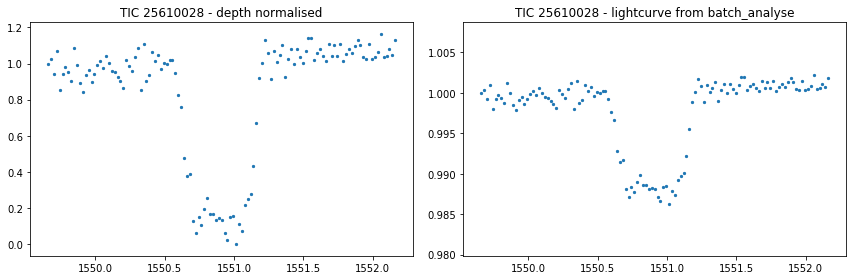

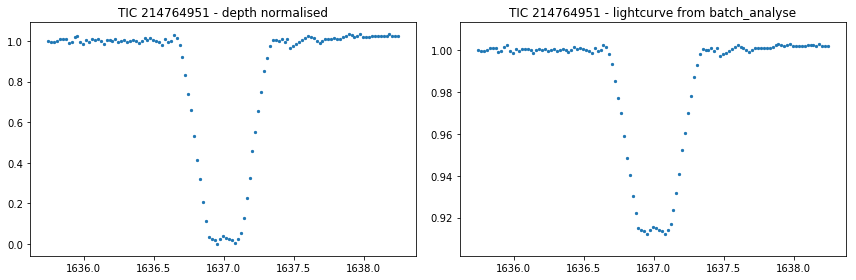

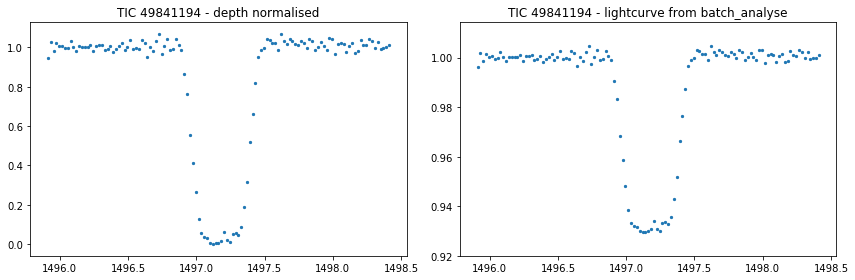

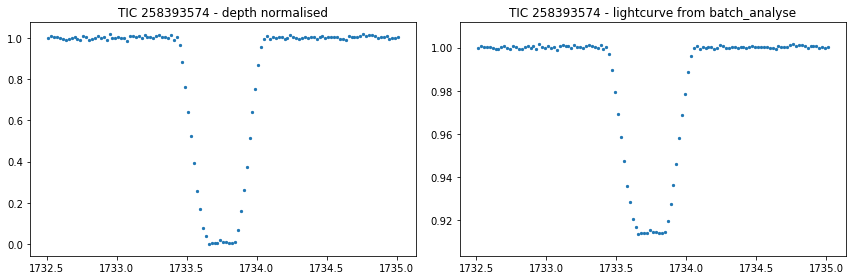

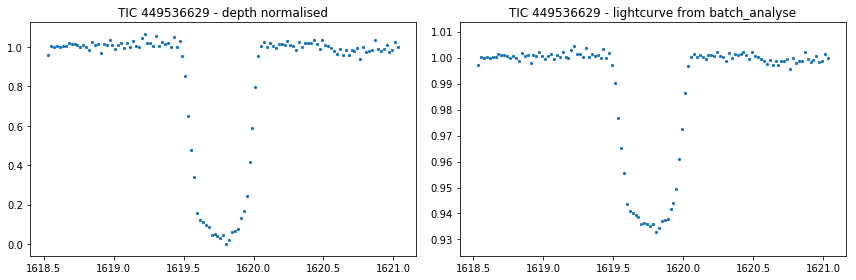

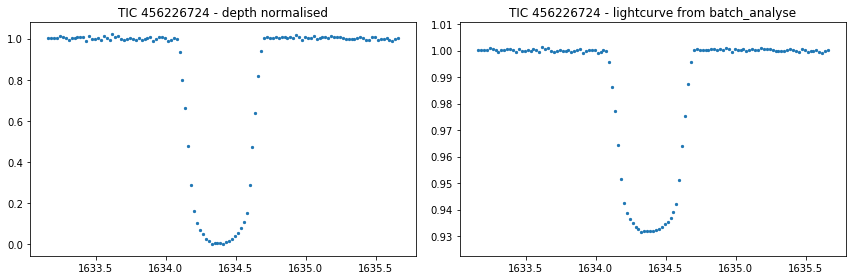

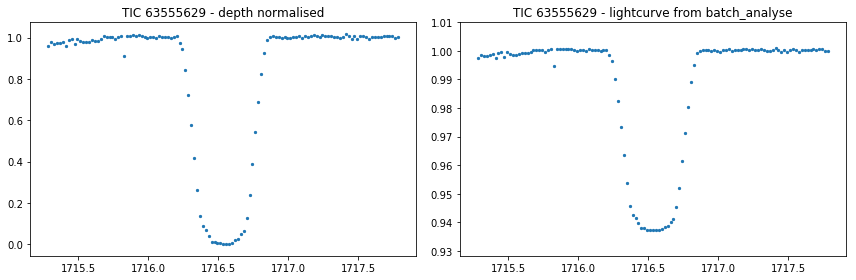

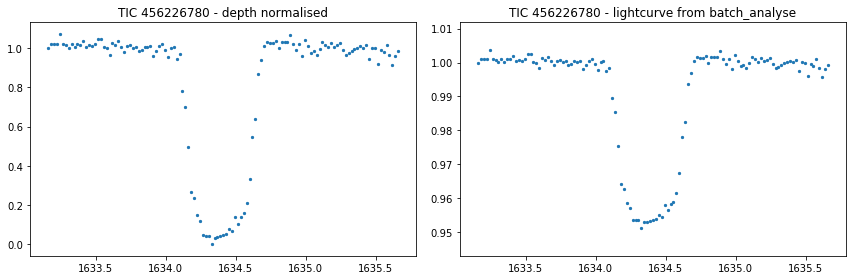

65


In [27]:
def get_lightcurves(ids,mapped_tuples,pixel, directory):
    """
    This function retrieves lightcurves in the SOM pixels. 
    
    :ids: TIC IDs from `stack_npz_files`
    :mapped_tuples: Obtained from the SOM process, where this is the coordinates of the lightcurve
    :pixel: desired pixel to retrieve lightcurves
    :dir: Directory of where original `.npz` files are.
    
    outputs:
        lightcurve plots.
    pixel has to be in the form of (x,y) coordinates"""
    df = pd.DataFrame(data=[ids,mapped_tuples]).T
    
    pdf_pages = PdfPages("pixel_{}.pdf".format(pixel))
    ## change tuples to columns for faster calculations
    df.columns = ['TIC','coords']
    lightcurves = df.groupby('coords').get_group(pixel).reset_index(drop=True)
    ids_in_pixel = []
    for i in lightcurves.TIC:
        #file_pattern = os.path.join(directory, '**', f'*{number_}*')
        lc = np.load("som_cutouts_snr6_old/{}.npz".format(i))
        ids_in_pixel.append(i)
        median = np.median(lc['flux'])
        abs_depth = median - np.min(lc['flux'])  # Assuming the minimum of the lightcurve is the minimum point
        depth_normalised_lightcurve = (lc['flux'] - median) / abs_depth + 1
        
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns of subplots
        plt.title("TIC {}".format(i))

        # First subplot (left side)
        axs[0].set_title("TIC {} - depth normalised".format(i))
        axs[0].scatter(lc['time'], depth_normalised_lightcurve, s=5)

        # Second subplot (right side)
        axs[1].set_title("TIC {} - lightcurve from batch_analyse".format(i))
        axs[1].scatter(lc['time'], lc['flux']/np.median(lc['flux']), s=5)

        plt.tight_layout()  # To ensure proper spacing between subplots
        plt.show()
        
        pdf_pages.savefig(fig)
    pdf_pages.close()

        
    print(len(ids_in_pixel))
    return df, ids_in_pixel
df, pixel = get_lightcurves(ids,mapped_tuples,(2,2),'som_cutouts_snr6_old/')

---

## Part 2: Remove common pixels and re-run the SOM

In [28]:
def remove_common_lightcurves(ids, mapped_tuples, tics_to_remove):
    # Create a DataFrame from your data
    df = pd.DataFrame(data={'TIC': ids, 'coords': mapped_tuples})

    # Remove rows with TIC values in tics_to_remove
    df = df[~df['TIC'].isin(tics_to_remove)]

    return df 

def restack_npz_files(directory, pattern_values):
    """normalization method: median, depth, depth and width"""
    files = os.listdir(directory)
    npz_files = [f for f in files if f.endswith('.npz') and any(str(value) in f for value in pattern_values)]
    
    normalised_by_median = []
    normalised_by_depth = [] 
    ids = []
    
    for npz_file in npz_files:
        file_path = os.path.join(directory, npz_file)
        data = np.load(file_path)   

        
        ## background subtraction
        x1 = np.median(data['flux'][0:12])
        x2 = np.median(data['flux'][-13:-1]) # the last 12 points

        y1 = np.median(data['time'][0:24])
        y2 = np.mean(data['time'][-25:-1])
        grad = (x2-x1)/(y2-y1)
        background_level = x1 + grad * (data['time'] - y1)
        original_flux = data['flux'].copy()
        
        flux = original_flux - background_level

        obj_id = data['id']
        
        ## normalisation method
        
               
        normalised_lightcurve = (flux)/np.median(flux)
        median = np.median(flux)
        #depth_normalised_lightcurve = (data['flux'] - median) / median
        abs_depth = median - np.min(flux)  # Assuming the minimum of the lightcurve is the minimum point
        depth_normalised_lightcurve = ((flux - median) / abs_depth + 1)
        #elif normalisation_method == 'depth and width':
        
        abs_depth_unsubtracted = np.median(original_flux) - np.min(original_flux)
        depth_normalised_lightcurve_unsubtracted = ((original_flux - np.median(original_flux)) / abs_depth_unsubtracted + 1)
        
#         fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns of subplots
        
#         ax[0].scatter(data['time'],depth_normalised_lightcurve,s=5)
#         ax[0].set_title("TIC {} - unsubtracted background".format(data['id']))
#         ax[1].scatter(data['time'],depth_normalised_lightcurve_unsubtracted,s=5)
#         ax[1].set_title("TIC {} - subtracted background".format(data['id']))
#         #plt.title(data['id'])
#         plt.show()
        
        
#         normalised_lightcurve = (data['flux'])/np.median(data['flux'])
#         median = np.median(data['flux'])
#         #depth_normalised_lightcurve = (data['flux'] - median) / median
#         abs_depth = median - np.min(data['flux'])  # Assuming the minimum of the lightcurve is the minimum point
#         depth_normalised_lightcurve = ((data['flux'] - median) / abs_depth + 1)
#         #elif normalisation_method == 'depth and width':
#         plt.scatter(data['time'],depth_normalised_lightcurve,s=5)
#         plt.title(data['id'])
#         plt.show()
        
        
        if len(normalised_lightcurve) == 121:
            normalised_by_median.append(normalised_lightcurve)
            normalised_by_depth.append(depth_normalised_lightcurve)
            ids.append(obj_id.item())


    stacked_median_lcs = np.vstack(normalised_by_median)
    stacked_depth_lcs = np.vstack(normalised_by_depth)
    stacked_ids = ids

    # Create a dictionary to map arrays to IDs
    id_map = {tuple(array): id for array, id in zip(stacked_median_lcs, stacked_ids)}
    return stacked_median_lcs, stacked_depth_lcs, stacked_ids, id_map

In [29]:
df = remove_common_lightcurves(ids,mapped_tuples, pixel)
#df2 = remove_common_lightcurves(ids,mapped_tuples, pixel2)

In [30]:
len(df)

3409

In [31]:
_, som_array_v2, ids, id_map = restack_npz_files('som_cutouts_snr6_old/',pattern_values=df['TIC'].to_list())

---

In [32]:
kshape2 = (10,10)

In [34]:
trained_data2 = CreateSOM(som_array_v2,somshape=kshape2,niter=500,learningradius=0.1)

## map the data onto a pixel
mapped2 = trained_data2(som_array_v2)
mapped_tuples2 = [tuple(point) for point in mapped2]
## count how many are in that pixel
counts2 = Counter(mapped_tuples2)
count_list2 = [counts[item] for item in mapped_tuples2]

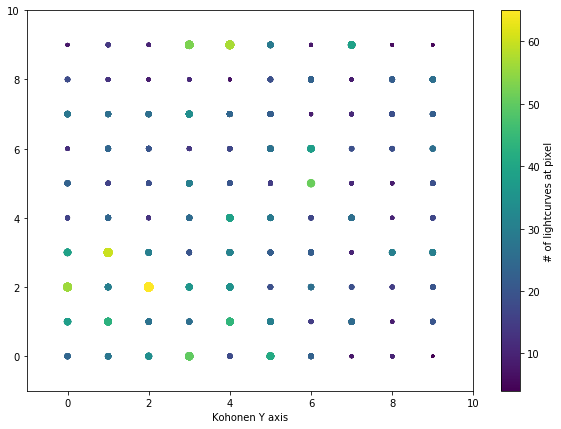

In [35]:
x_pos2 = mapped2[:,0]
y_pos2 = mapped2[:,1]
count_list = [counts2[item] for item in mapped_tuples2]
plt.figure(figsize=(10,7))
plt.xlim([-1,kshape2[0]])
plt.ylim([-1,kshape2[1]])
plt.xlabel('Kohonen X axis')
plt.xlabel('Kohonen Y axis')
plt.scatter(x_pos2,y_pos2,c=count_list2,s=count_list2)
plt.colorbar(label='# of lightcurves at pixel')
plt.savefig('kohonen_layers.png')
plt.show()

In [36]:
array2 = trained_data2.K

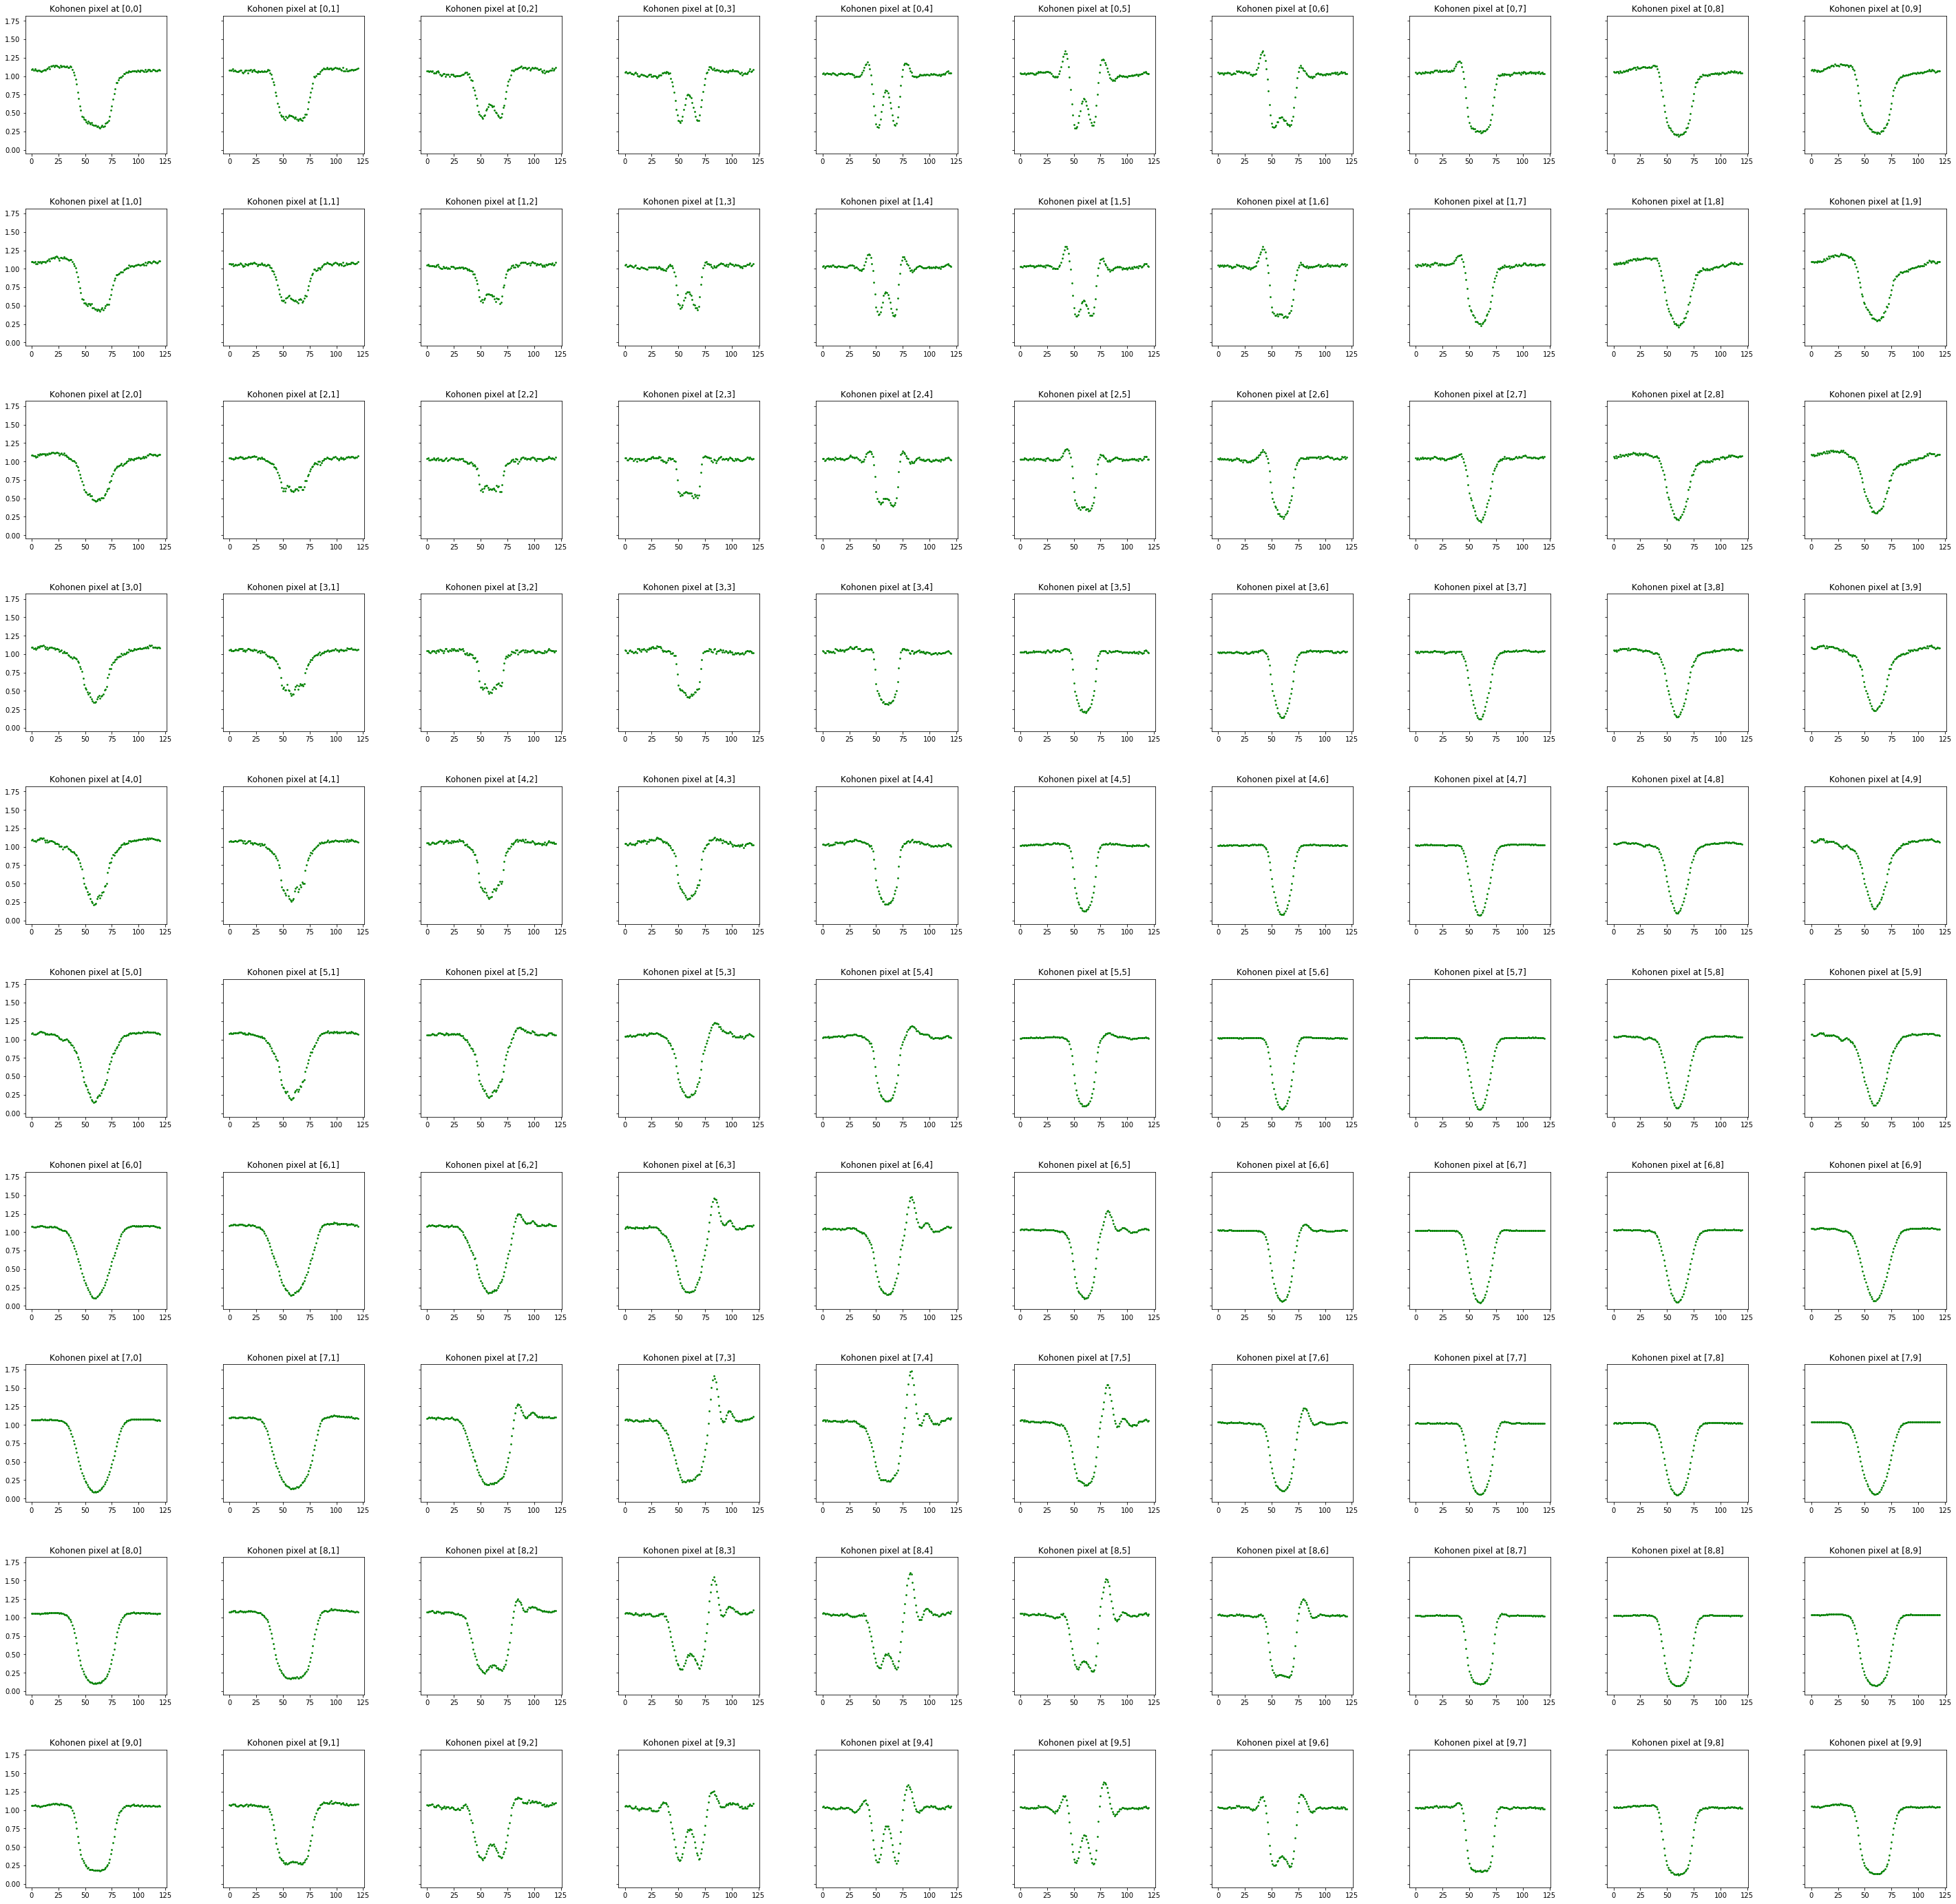

In [37]:
plot_all_arrays(array2,kshape=kshape2)

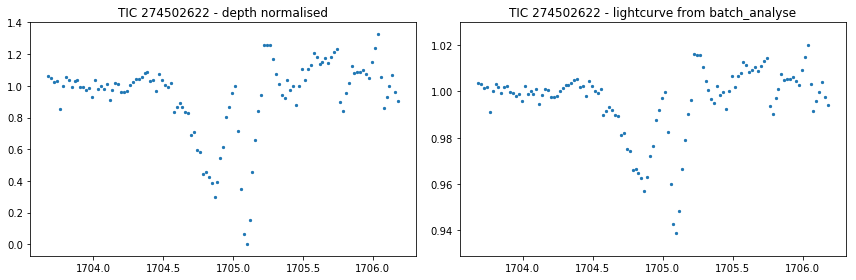

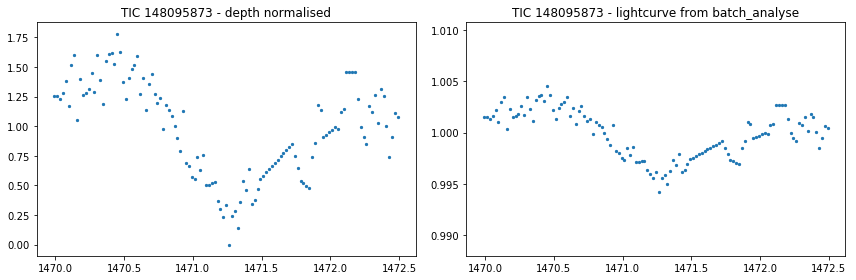

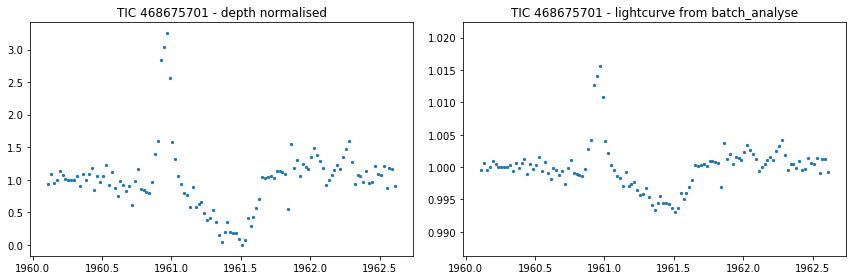

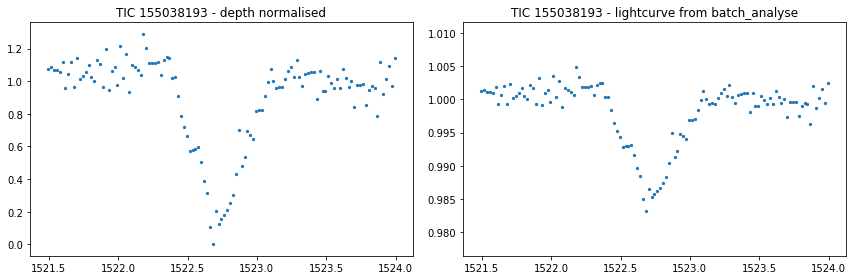

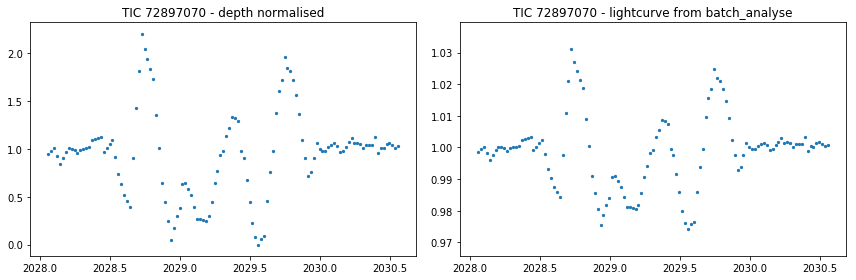

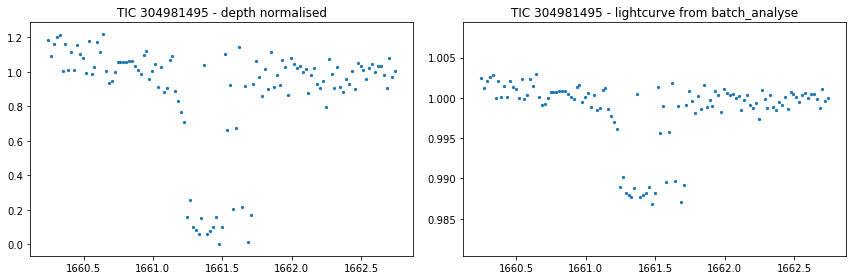

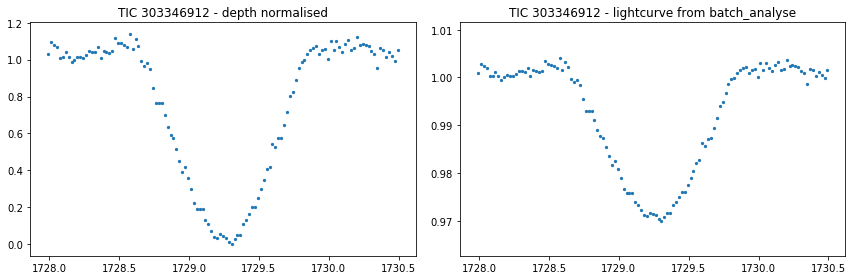

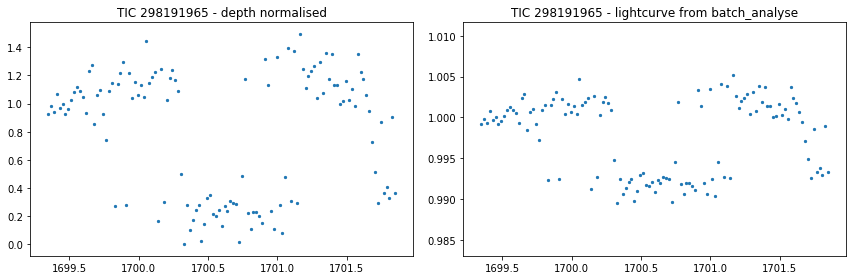

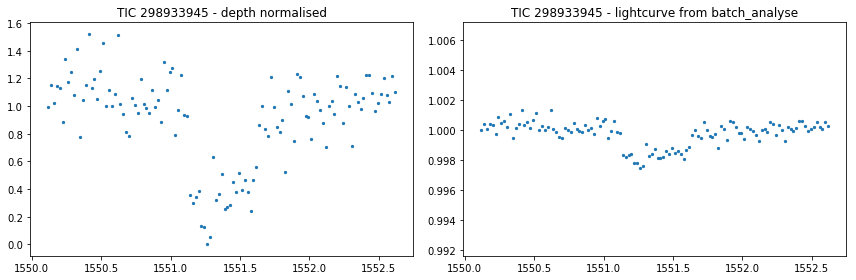

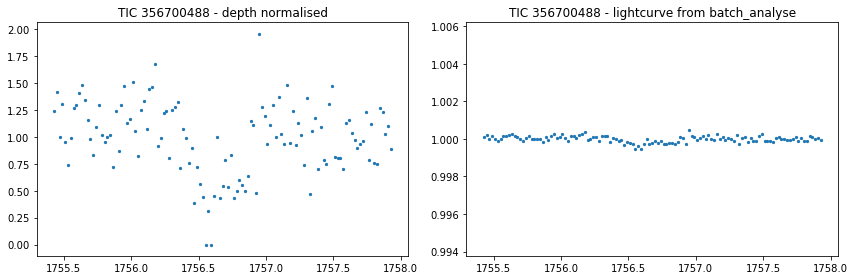

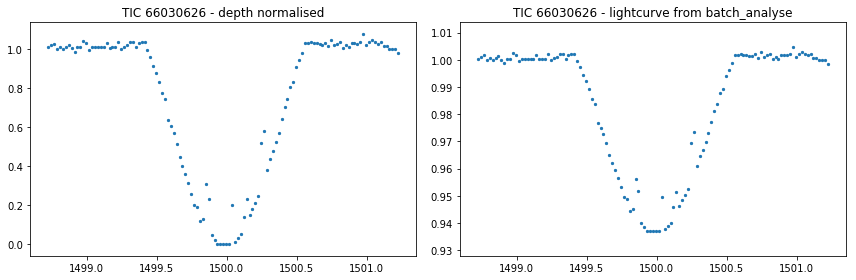

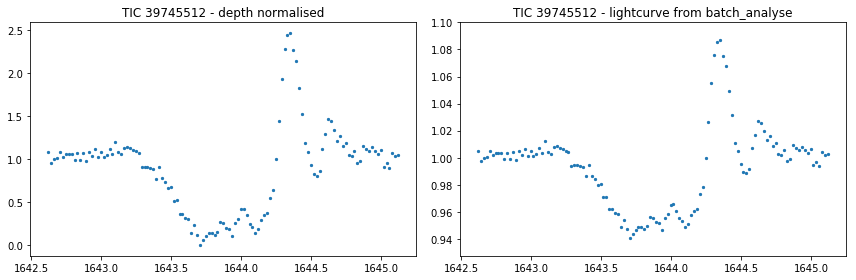

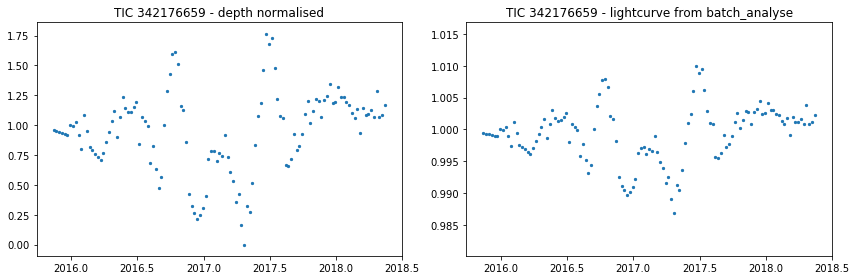

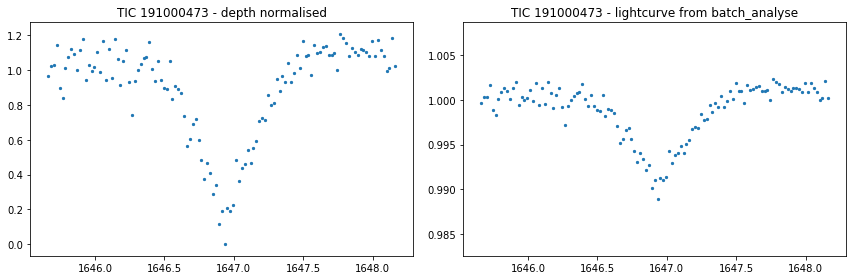

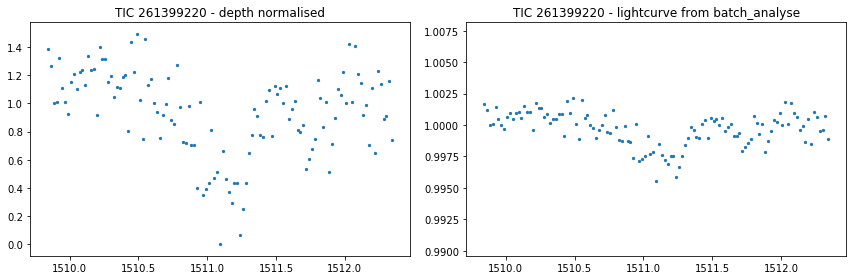

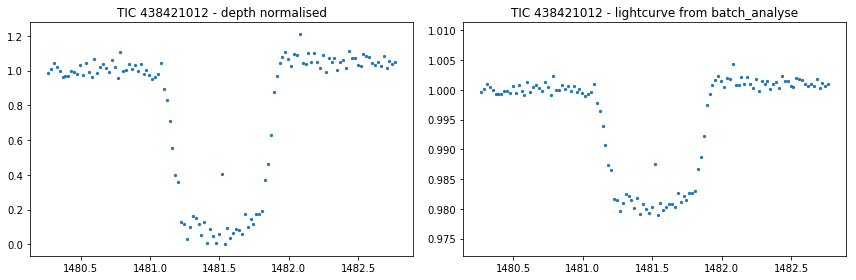

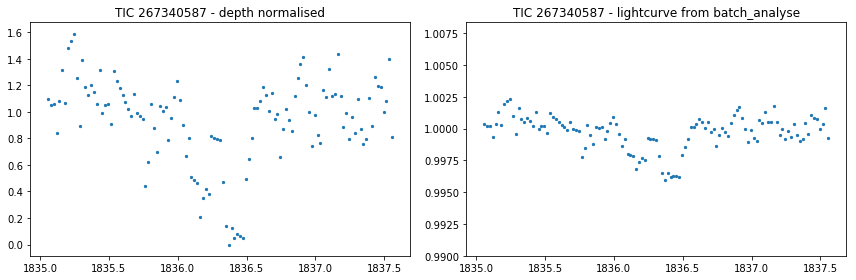

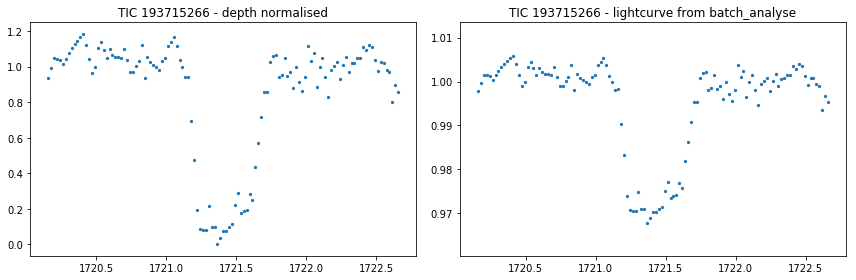

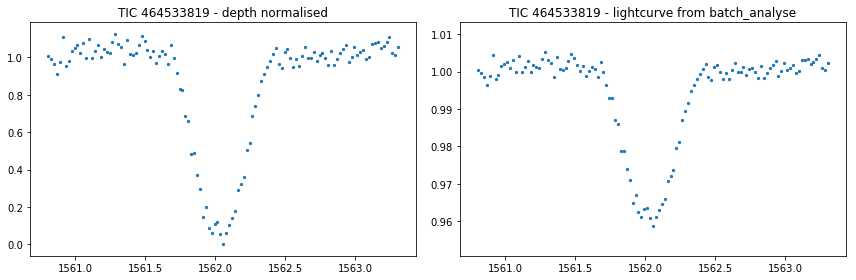

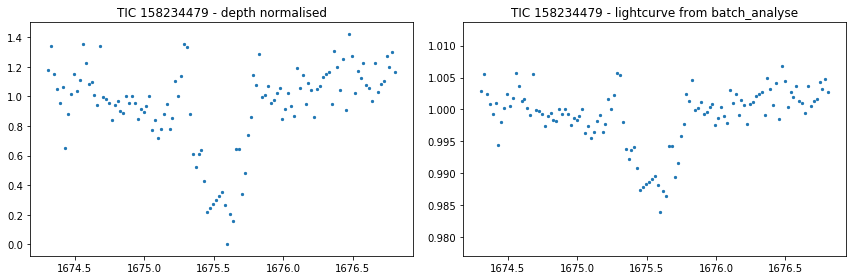

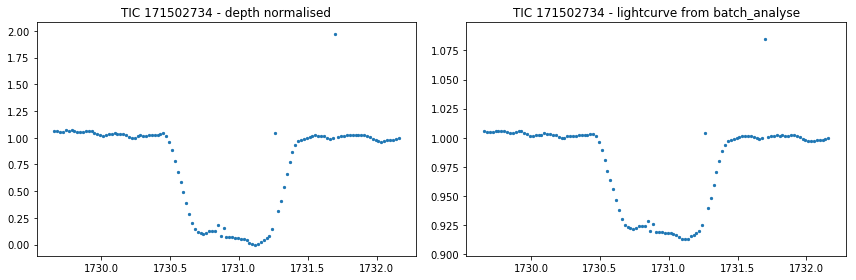

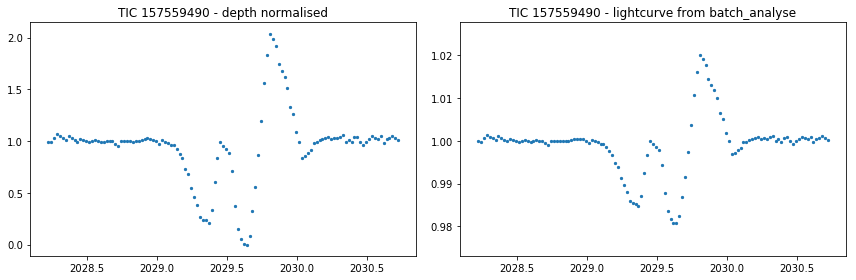

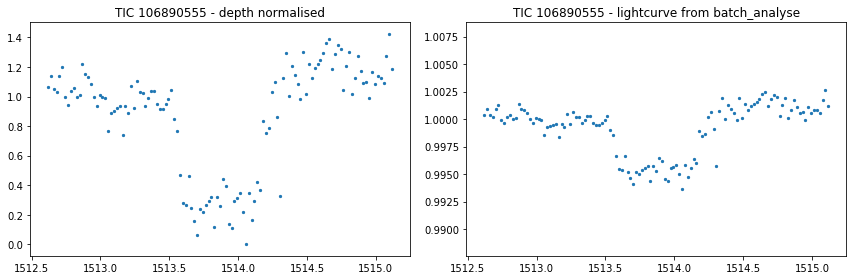

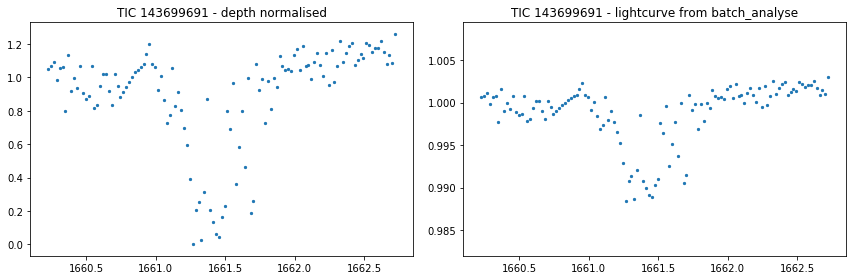

24


In [38]:
_, pixel2 = get_lightcurves(ids,mapped_tuples,(1,4),'som_cutouts_snr6_v2/')

---